In [1]:
# install library newsapi dan NLTK
!pip install newsapi-python
!pip install tensorflow

In [2]:
!pip install nltk

In [46]:
from newsapi import NewsApiClient
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

import re
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer # Changed import statement
from tensorflow.keras.utils import pad_sequences # Changed import statement
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, LSTM, Embedding, Dense, MultiHeadAttention, Dropout, LayerNormalization

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from keras.layers import Attention, Concatenate

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Function

In [4]:
# cleansing text
def text_cleansing(text):
    # Lowercasing
    text = text.lower()
    # Remove the pattern "[+digits chars]"
    text = re.sub(r'\[\+\d+\schars\]', '', text).strip()
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Join back to a string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Fungsi scraping dataset
def news_scrape(YOUR_API_KEY, q, from_param, to, language='en', sort_by='popularity', max_page=1):
    # Init NewsAPI
    newsapi = NewsApiClient(api_key=YOUR_API_KEY)
    df_all = pd.DataFrame()
    for i in range(1,max_page+1):
        all_articles = newsapi.get_everything(q=q, from_param=from_param, to=to,
                                              language=language, sort_by=sort_by, page=i)
        df_tmp = pd.json_normalize(all_articles['articles'])
        df_all = pd.concat([df_all, df_tmp], axis=0).reset_index(drop=True)

    df_all = df_all.drop_duplicates()
    return df_all

def decode_sequence(seq, tokenizer):
    reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
    return ' '.join([reverse_word_index.get(i, '<UNK>') for i in seq if i != 0])

# Get Data & Cleansing

In [5]:
YOUR_API_KEY = '1a13883e32e54d14915ebe98f11270e5'
df_all = news_scrape(YOUR_API_KEY, q='bitcoin', from_param='2025-04-19', to='2025-04-26',
                     language='en', sort_by='popularity', max_page=5)

# apply text cleansing
df_all['content'] = df_all['content'].astype(str).apply(text_cleansing)
df_all['title'] = df_all['title'].astype(str).apply(text_cleansing)

In [6]:
df_all.shape

(496, 9)

In [7]:
df_all.head()

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
0,Matt Novak,trump plans private dinner for largest buyers ...,Trump's corruption knows no bounds.,https://gizmodo.com/trump-plans-private-dinner...,https://gizmodo.com/app/uploads/2025/04/donald...,2025-04-24T12:48:24Z,president donald trump launched his own crypto...,None,Gizmodo.com
1,Grace Eliza Goodwin,palantir once bought 50 million worth of gold ...,Palantir sold its gold bars for a small profit...,https://www.businessinsider.com/golds-value-do...,https://i.insider.com/68080243c6ad288d147ed7be...,2025-04-23T18:01:17Z,the value of gold has reached record highs thi...,business-insider,Business Insider
2,None,bitcoin rallies during market turmoil,None,https://consent.yahoo.com/v2/collectConsent?se...,None,2025-04-22T17:02:29Z,if you click accept all we and our partners in...,None,Yahoo Entertainment
3,Yei Ling Ma,new report exposes stunning shift that could r...,"In 2011, only 20% of the industry's activities...",https://finance.yahoo.com/news/report-exposes-...,https://s.yimg.com/ny/api/res/1.2/KFw6OQ_d6F1r...,2025-04-25T11:00:06Z,a new report published by nodiens a risk metri...,None,Yahoo Entertainment
4,None,surprising 556m bitcoin buy pushes strategys h...,None,https://consent.yahoo.com/v2/collectConsent?se...,None,2025-04-21T12:17:26Z,if you click accept all we and our partners in...,None,Yahoo Entertainment


In [8]:
df = df_all.copy()

In [57]:
df.to_csv('news_summary.csv', index=False)

In [ ]:
df = pd.read_csv('news_summary.csv')

# Data Preparation

In [9]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['content'] + df['title'])

max_input_len = 30
max_output_len = 10

encoder_input = pad_sequences(tokenizer.texts_to_sequences(df['content']), maxlen=max_input_len, padding='post')
decoder_input = pad_sequences(tokenizer.texts_to_sequences(df['title']), maxlen=max_output_len, padding='post')

In [10]:
df['content'][0], encoder_input[0]

('president donald trump launched his own cryptocurrency just before taking office in january in one of the most blatantly unethical financial schemes from any us president of the modern era and whi',
 array([  33, 1237,  134,  678,   43,  213,  361,  886,  679,    5,  233,
           5,   95,    7,    2,  114, 1952, 1953,  135, 1238,   21, 1239,
          19,   69,    7,    2, 1954,  887,    6,    1], dtype=int32))

In [11]:
df['title'][0], decoder_input[0]

('trump plans private dinner for largest buyers of trump crypto',
 array([ 33, 559, 888, 403,  13, 198, 889,   7,  33,  14], dtype=int32))

In [12]:
# Target output shift one step to the left
decoder_output = []
for seq in decoder_input:
    shifted = seq[1:]
    shifted = list(shifted) + [0]
    decoder_output.append(shifted)

In [13]:
decoder_output[0]

[np.int32(559),
 np.int32(888),
 np.int32(403),
 np.int32(13),
 np.int32(198),
 np.int32(889),
 np.int32(7),
 np.int32(33),
 np.int32(14),
 0]

# Split X (train, test) and Y (train, test)

In [14]:
# Konversi array input/output
X_encoder = np.array(encoder_input)
X_decoder_input = np.array(decoder_input)
Y_decoder_output = np.expand_dims(np.array(decoder_output), -1)

# Split data (80% train, 20% test)
X_enc_train, X_enc_test, X_dec_train, X_dec_test, y_train, y_test = train_test_split(
    X_encoder, X_decoder_input, Y_decoder_output, test_size=0.2, random_state=42)

In [15]:
print(y_test[0].flatten())
print(decode_sequence(y_test[0].flatten(), tokenizer))

[1127 1233  190    4  228  365  101    0    0    0]
adds staked solana to two tech etfs


# Model 1: Encoder-Decoder Dasar dengan LSTM

In [16]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 64
latent_dim = 128

In [17]:
# Encoder
encoder_inputs = Input(shape=(max_input_len,))
encoder_embedding = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)

2025-04-26 15:32:49.901528: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [18]:
# Decoder
decoder_inputs = Input(shape=(max_output_len,))
decoder_embedding = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [19]:
# Model
model_lstm = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 64)    │    283,648 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 10, 64)    │    283,648 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     98,816 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 10, 128)   │     98,816 │ embedding_1[0][0… │
│                     │                   │            │ lstm[0][1],       │
│                     │                   │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 4432)  │    571,728 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,336,656 (5.10 MB)

 Trainable params: 1,336,656 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model_lstm.fit([X_enc_train, X_dec_train], y_train, batch_size=2, epochs=10)

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 6.9655
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 5.2979
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 4.9142
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.7789
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.7396
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.5637
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.6727
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.3885
Epoch 9/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.2028
Epoch 10/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 4.2039


In [21]:
for i in range(5):
    input_seq = X_enc_test[i:i+1]
    decoder_input_seq = X_dec_test[i:i+1]
    pred = model_lstm.predict([input_seq, decoder_input_seq])
    pred_seq = np.argmax(pred[0], axis=1)

    print("Artikel:", decode_sequence(input_seq[0], tokenizer))
    print("Judul Asli:", decode_sequence(y_test[i].flatten(), tokenizer))
    print("Judul Prediksi:", decode_sequence(pred_seq, tokenizer))
    print("-" * 60)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Artikel: exposure to staked solana sol to the portfolios of two of its exchangetraded funds etfs the asset manager said in a client email reviewed by cointelegraph as of april 21
Judul Asli: adds staked solana to two tech etfs
Judul Prediksi: is bitcoin bitcoin bitcoin see see in rally
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Artikel: windowopenthishref blank 200 return falsegtwhy is the ftc suing uber windowopenthishref blank 200 return falsegthow are trump tariffs impacting us businesses
Judul Asli: aim at puerto rico tax perks for crypto investors
Judul Prediksi: to the the of the tariff and rally rally
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Artikel: whatsapp introduces advanced chat privacy to protect sensitive communications android spyware hidden in mapping software targets russian soldiers crypto mining campaign targets dock

In [22]:
smoothie = SmoothingFunction().method4

bleu_scores = []

for i in range(len(X_enc_test)):
    input_seq = X_enc_test[i:i+1]
    decoder_input_seq = X_dec_test[i:i+1]
    pred = model_lstm.predict([input_seq, decoder_input_seq])
    pred_seq = np.argmax(pred[0], axis=1)

    reference = [decode_sequence(y_test[i].flatten(), tokenizer).split()]
    candidate = decode_sequence(pred_seq, tokenizer).split()

    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    bleu_scores.append(score)

print(f"Rata-rata BLEU Score: {np.mean(bleu_scores):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

<Axes: ylabel='Count'>

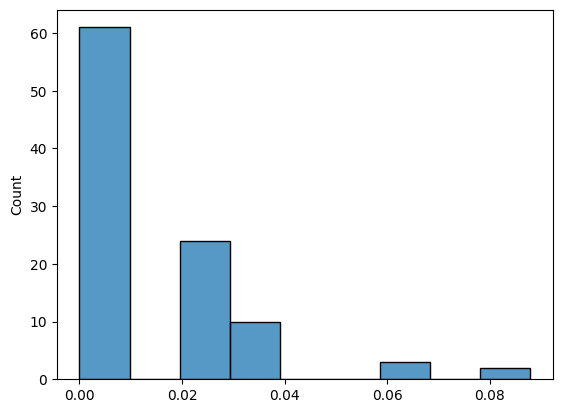

In [23]:
sns.histplot(bleu_scores)

# Model 2: Encoder-Decoder dengan Attention

In [24]:
# Encoder
encoder_inputs_att = Input(shape=(max_input_len,))
encoder_embedding_att = Embedding(vocab_size, embedding_dim)(encoder_inputs_att)
encoder_lstm_att, state_h_att, state_c_att = LSTM(latent_dim, return_sequences=True, return_state=True)(encoder_embedding_att)

In [25]:
# Decoder
decoder_inputs_att = Input(shape=(max_output_len,))
decoder_embedding_att = Embedding(vocab_size, embedding_dim)(decoder_inputs_att)
decoder_lstm_att = LSTM(latent_dim, return_sequences=True)
decoder_lstm_outputs = decoder_lstm_att(decoder_embedding_att, initial_state=[state_h_att, state_c_att])

In [26]:
# Attention Layer
attention = Attention()([decoder_lstm_outputs, encoder_lstm_att])
concat = Concatenate(axis=-1)([decoder_lstm_outputs, attention])
decoder_dense_att = Dense(vocab_size, activation='softmax')
decoder_outputs_att = decoder_dense_att(concat)

In [27]:
# Model
model_attention = Model([encoder_inputs_att, decoder_inputs_att], decoder_outputs_att)
model_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model_attention.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 30, 64)    │    283,648 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 10, 64)    │    283,648 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 30, 128), │     98,816 │ embedding_2[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 10, 128)   │     98,816 │ embedding_3[0][0… │
│                     │                   │            │ lstm_2[0][1],     │
│                     │                   │            │ lstm_2[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 10, 128)   │          0 │ lstm_3[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10, 256)   │          0 │ lstm_3[0][0],     │
│ (Concatenate)       │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10, 4432)  │  1,139,024 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,903,952 (7.26 MB)

 Trainable params: 1,903,952 (7.26 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
model_attention.fit([X_enc_train, X_dec_train], y_train, batch_size=2, epochs=10)

Epoch 1/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 6.9293
Epoch 2/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 5.1609
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 5.0408
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 4.8322
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 4.7849
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 4.4336
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 4.2438
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 3.9047
Epoch 9/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 3.7837
Epoch 10/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 3.3657


In [29]:
for i in range(5):
    input_seq = X_enc_test[i:i+1]
    decoder_input_seq = X_dec_test[i:i+1]
    pred = model_attention.predict([input_seq, decoder_input_seq])
    pred_seq = np.argmax(pred[0], axis=1)

    print("Artikel:", decode_sequence(input_seq[0], tokenizer))
    print("Judul Asli:", decode_sequence(y_test[i].flatten(), tokenizer))
    print("Judul Prediksi:", decode_sequence(pred_seq, tokenizer))
    print("-" * 60)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
Artikel: exposure to staked solana sol to the portfolios of two of its exchangetraded funds etfs the asset manager said in a client email reviewed by cointelegraph as of april 21
Judul Asli: adds staked solana to two tech etfs
Judul Prediksi: crypto crypto crypto btc america amid amid price
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Artikel: windowopenthishref blank 200 return falsegtwhy is the ftc suing uber windowopenthishref blank 200 return falsegthow are trump tariffs impacting us businesses
Judul Asli: aim at puerto rico tax perks for crypto investors
Judul Prediksi: is the the the the the the the deal
------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Artikel: whatsapp introduces advanced chat privacy to protect sensitive communications android spyware hidden in mapping software targets russian soldiers crypto mining campaign targets dock

In [30]:
smoothie = SmoothingFunction().method4

bleu_scores = []

for i in range(len(X_enc_test)):
    input_seq = X_enc_test[i:i+1]
    decoder_input_seq = X_dec_test[i:i+1]
    pred = model_attention.predict([input_seq, decoder_input_seq])
    pred_seq = np.argmax(pred[0], axis=1)

    reference = [decode_sequence(y_test[i].flatten(), tokenizer).split()]
    candidate = decode_sequence(pred_seq, tokenizer).split()

    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    bleu_scores.append(score)

print(f"Rata-rata BLEU Score: {np.mean(bleu_scores):.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

<Axes: ylabel='Count'>

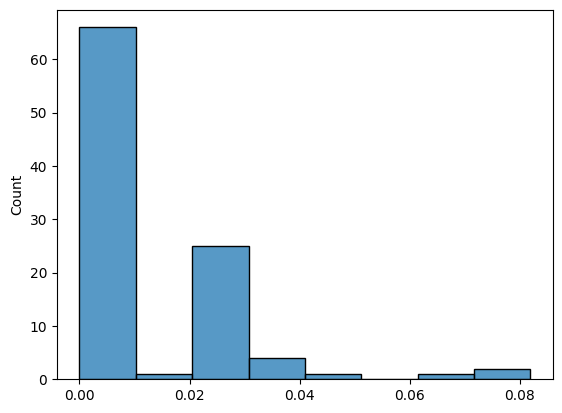

In [31]:
sns.histplot(bleu_scores)

# Model 3: Transformer

In [47]:
# ============ 1. Load Data ============
# Misal: df sudah ada
# df = pd.read_csv('news.csv') 

contents = df['content'].astype(str).tolist()
titles = df['title'].astype(str).tolist()

In [48]:
# ============ 2. Tokenisasi ============
tokenizer_content = Tokenizer()
tokenizer_title = Tokenizer()

tokenizer_content.fit_on_texts(contents)
tokenizer_title.fit_on_texts(titles)

X = tokenizer_content.texts_to_sequences(contents)
y = tokenizer_title.texts_to_sequences(titles)

max_input_len = 30
max_output_len = 30

X_enc = pad_sequences(X, maxlen=max_input_len, padding='post')
y_dec = pad_sequences(y, maxlen=max_output_len, padding='post')

X_enc_train = X_enc
y_train = np.expand_dims(y_dec, -1)

vocab_size_content = len(tokenizer_content.word_index) + 1
vocab_size_title = len(tokenizer_title.word_index) + 1
embedding_dim = 128

In [49]:
# ============ 3. Transformer Encoder Layer ============
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, head_size, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.head_size = head_size
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.attention = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.head_size)
        self.dropout1 = Dropout(self.dropout)
        self.norm1 = LayerNormalization(epsilon=1e-6)

        self.ffn = tf.keras.Sequential([
            Dense(self.ff_dim, activation="relu"),
            Dense(input_shape[-1])  # <<< ini otomatis ambil dimensi input
        ])
        self.dropout2 = Dropout(self.dropout)
        self.norm2 = LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=False):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)

In [50]:
# ============ 4. Build Model ============
input_layer = Input(shape=(max_input_len,))
x = Embedding(input_dim=vocab_size_content, output_dim=embedding_dim)(input_layer)

x = TransformerEncoder(head_size=64, num_heads=2, ff_dim=128)(x)
x = TransformerEncoder(head_size=64, num_heads=2, ff_dim=128)(x)

# Output per token
output_layer = Dense(vocab_size_title, activation='softmax')(x)

transformer_model = Model(inputs=input_layer, outputs=output_layer)
transformer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

transformer_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 30, 128)        │       452,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 30, 128)        │        99,584 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_4           │ (None, 30, 128)        │        99,584 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 30, 1936)       │       249,744 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 901,136 (3.44 MB)

 Trainable params: 901,136 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# ============ 5. Train Model ============
transformer_model.fit(X_enc_train, y_train, batch_size=16, epochs=10, validation_split=0.1)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 5.5623 - val_loss: 3.2460
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 2.8649 - val_loss: 3.3398
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 2.9222 - val_loss: 3.3923
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 2.9657 - val_loss: 3.4522
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 2.8683 - val_loss: 3.4432
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 2.7642 - val_loss: 3.4927
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 2.5913 - val_loss: 3.5456
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 2.3069 - val_loss: 3.5837
Epoch 9/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 2.1140 - val_loss: 3.6627
Epoch 10/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 1.9177 - val_loss: 3.8213


In [52]:
# ============ 6. Inference (Generate Title) ============
def generate_title(article_text):
    seq = tokenizer_content.texts_to_sequences([article_text])
    padded = pad_sequences(seq, maxlen=max_input_len, padding='post')
    
    pred = transformer_model.predict(padded)
    pred_sequence = np.argmax(pred[0], axis=-1)
    
    reverse_title_index = {v: k for k, v in tokenizer_title.word_index.items()}
    predicted_words = [reverse_title_index.get(idx, '') for idx in pred_sequence if idx != 0]
    
    return ' '.join(predicted_words)

In [53]:
# ============ 7. Contoh Prediksi ============
sample_article = df['content'].iloc[0]
generated_title = generate_title(sample_article)

print(f"Content: {sample_article}")
print(f"Judul Asli: {df['title'].iloc[0]}")
print(f"Generated Title: {generated_title}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Content: president donald trump launched his own cryptocurrency just before taking office in january in one of the most blatantly unethical financial schemes from any us president of the modern era and whi
Judul Asli: trump plans private dinner for largest buyers of trump crypto
Generated Title: the of


In [54]:
def evaluate_bleu(model, X_val, y_val, tokenizer_target, max_len=30):
    smooth = SmoothingFunction().method1
    total_bleu = 0
    n_samples = len(X_val)

    for i in range(n_samples):
        input_seq = X_val[i:i+1]
        true_seq = y_val[i]
        
        # Prediksi
        pred = model.predict(input_seq, verbose=0)
        pred_seq = np.argmax(pred[0], axis=-1)
        
        # Konversi ke kata
        reverse_target_word_index = {v: k for k, v in tokenizer_target.word_index.items()}
        pred_words = [reverse_target_word_index.get(idx, '') for idx in pred_seq if idx != 0]
        true_words = [reverse_target_word_index.get(idx, '') for idx in true_seq.flatten() if idx != 0]

        # BLEU Score
        bleu = sentence_bleu([true_words], pred_words, smoothing_function=smooth)
        total_bleu += bleu

    return total_bleu / n_samples

In [55]:
bleu_scores = []

for epoch in range(10):  # Misal 10 epochs
    print(f"Epoch {epoch+1}")
    transformer_model.fit(X_enc_train, y_train, batch_size=16, epochs=1, verbose=1, validation_split=0.1)
    
    bleu = evaluate_bleu(transformer_model, X_enc_train[:50], y_train[:50], tokenizer_title)  # sampling 50 data saja biar cepat
    bleu_scores.append(bleu)
    
    print(f"BLEU Score: {bleu:.4f}")

Epoch 1
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 1.6499 - val_loss: 3.8684
BLEU Score: 0.0395
Epoch 2
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 1.5026 - val_loss: 3.9558
BLEU Score: 0.0391
Epoch 3
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 1.3021 - val_loss: 4.0830
BLEU Score: 0.0599
Epoch 4
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 1.2016 - val_loss: 4.2468
BLEU Score: 0.1098
Epoch 5
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 1.0797 - val_loss: 4.4207
BLEU Score: 0.1275
Epoch 6
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.9397 - val_loss: 4.5347
BLEU Score: 0.2056
Epoch 7
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.8267 - val_loss: 4.6313
BLEU Score: 0.2302
Epoch 8
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.7522 - val_loss: 4.8280
BLEU Score: 0.4373
Epoch 9
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.6905 - val_loss: 4.8814
BLEU Score: 0.4875
Epoch 10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.6373 - val_loss: 5.0660
BLEU Sco

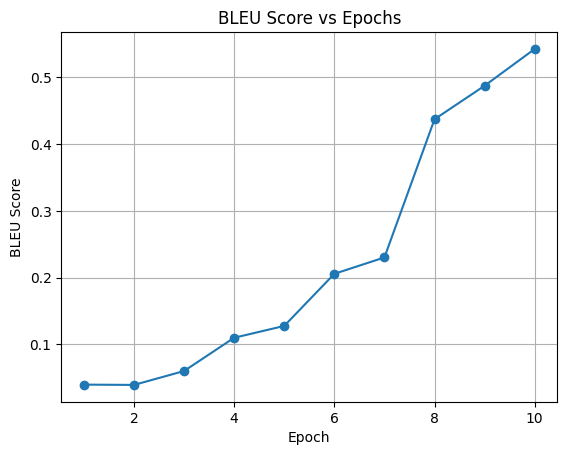

In [56]:
plt.plot(range(1, len(bleu_scores)+1), bleu_scores, marker='o')
plt.title('BLEU Score vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.grid()
plt.show()